In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import cv2
from tqdm import tqdm_notebook as tqdm

In [0]:
# path : /content/gdrive/My Drive/Datasets/Landscapes 
path = "/content/gdrive/My Drive/Datasets/Landscapes_snapshots"

In [0]:
%%capture
image_list = []
import os
for dirname, _, filename in tqdm(os.walk(path)) :
  for files in tqdm(filename) :
    i =  os.path.join(dirname, files)
    if i.endswith(".jpg") :
      image_list.append(i)

In [5]:
len(image_list)

4329

In [0]:
IMAGE_SIZE = (300, 300)
def load_image(image_path) : 
  image = cv2.imread(image_path) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (IMAGE_SIZE[0], IMAGE_SIZE[1]), interpolation = cv2.INTER_AREA)
  return image

def convert_lab(image) : 
  image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
  return image[:,:,0]
  
def plot_image(image) : 
  plt.figure(figsize = (20, 12))
  plt.imshow(image, cmap = "gray")
  plt.grid(False)

(300, 300, 3)


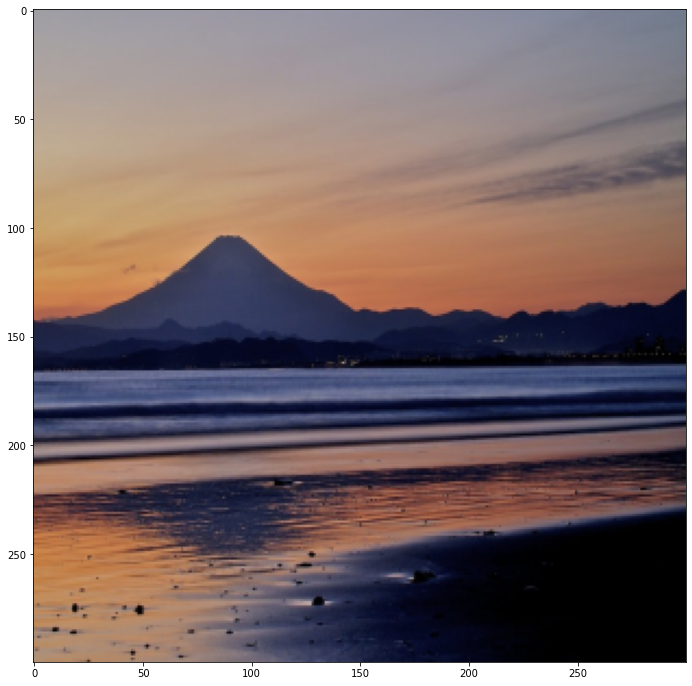

In [7]:
sample_image = load_image(image_list[32])
print(sample_image.shape)
plot_image(sample_image)

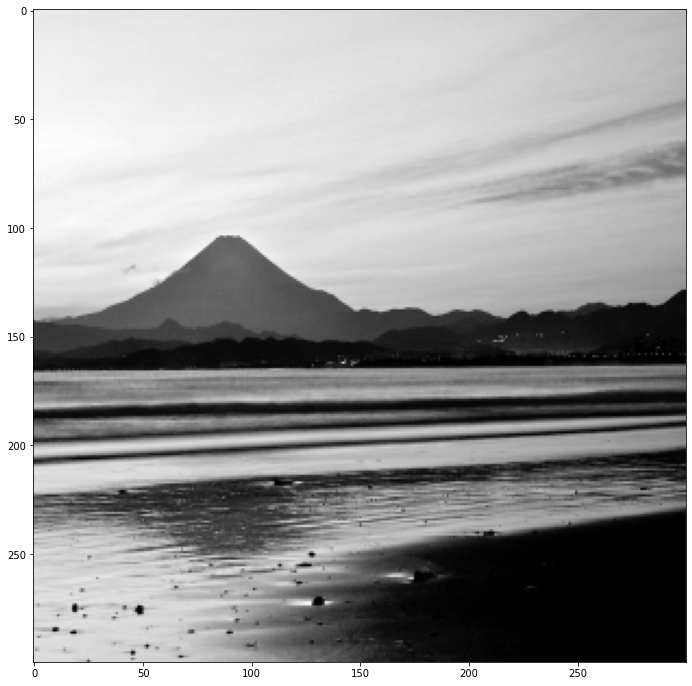

In [8]:
l = convert_lab(sample_image)
plot_image(l)

In [0]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 16
SPLIT_FACTOR = 0.85
EPOCHS = 200

In [10]:
l_images = []
target_images = []
for image_path in tqdm(image_list):
    image = load_image(image_path) 
    l_image = convert_lab(image)
    l_image = l_image.reshape(l_image.shape[0], l_image.shape[1], 1)    
    l_images.append(l_image)
    target_images.append(image[:, :, 1:])      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


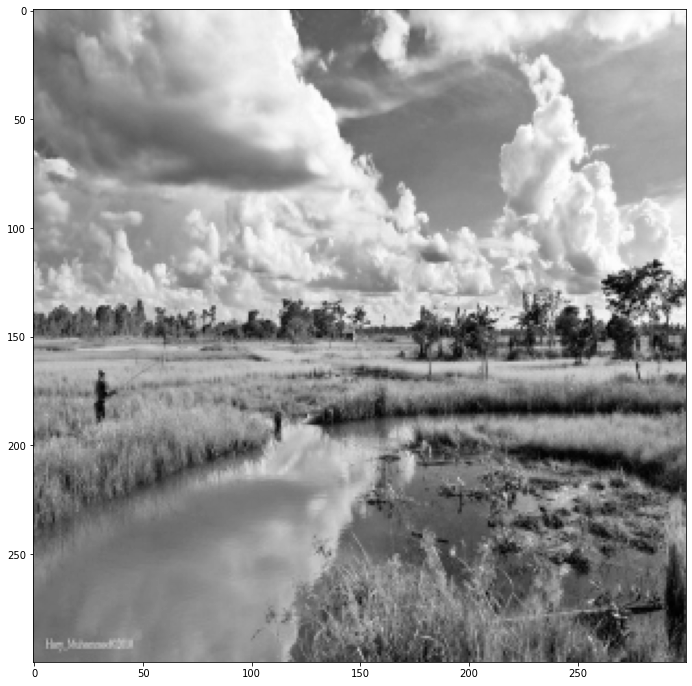

In [11]:
i = l_images[1000]
i = i.reshape(i.shape[0], i.shape[1])
plot_image(i)

In [0]:
l_images = np.array(l_images, dtype = np.float32)
target_images = np.array(target_images, dtype = np.float32)

In [0]:
np.save("l_images", l_images)
np.save("target_images", target_images)

In [0]:
def prepare_dataset(split_factor) : 
  x_train, y_train = l_images[0:int(len(l_images) * split_factor)], target_images[0:int(len(target_images) * split_factor)]
  x_val, y_val = l_images[int(len(l_images) * split_factor) : ] , target_images[int(len(target_images) * split_factor) :]
  return x_train, y_train, x_val, y_val

In [0]:
x_train, y_train, x_val, y_val = prepare_dataset(SPLIT_FACTOR)

In [16]:
print("Shape of training set = ",x_train.shape, y_train.shape)
print("Shape of validation set = ",x_val.shape, y_val.shape)

Shape of training set =  (3679, 300, 300, 1) (3679, 300, 300, 2)
Shape of validation set =  (650, 300, 300, 1) (650, 300, 300, 2)


# Deep Learning Architecture - AutoEncoder 

In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience = 25, restore_best_weights= False, verbose = True)

In [0]:
l_images = np.load("l_images.npy")
target_images = np.load("target_images.npy")

In [26]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size= (3,3), padding = "same", activation= "relu", input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1),
                                 strides = 2))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation= "relu"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation= "relu"))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu", strides = 2))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu"))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu"))

model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu"))
model.add(tf.keras.layers.UpSampling2D(size = (2,2)))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation= "relu"))
model.add(tf.keras.layers.UpSampling2D(size = (2,2)))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation= "relu"))
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size= (3,3), padding = "same", activation= "relu"))
model.add(tf.keras.layers.Conv2D(filters = 2, kernel_size= (3,3), padding = "same", activation= "tanh"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 150, 150, 128)     1280      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 150, 150, 64)      73792     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 75, 75, 32)        18464     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 75, 32)       

In [0]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.0001), loss = "MSE")

In [30]:
with tf.device("/device:GPU:0"):
  history = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = EPOCHS, verbose = 1, 
                      batch_size= BATCH_SIZE, callbacks = [reduce_lr, monitor_es], 
                      steps_per_epoch = np.ceil((len(x_train) / BATCH_SIZE)))   

Epoch 1/200
230/230 [==============================] - 132s 575ms/step - loss: 18840.7949 - val_loss: 19421.8730 - lr: 1.0000e-04
Epoch 2/200
230/230 [==============================] - 127s 552ms/step - loss: 18840.6699 - val_loss: 19421.8730 - lr: 1.0000e-04
Epoch 3/200
 11/230 [>.............................] - ETA: 1:43 - loss: 18676.7891

KeyboardInterrupt: ignored

In [0]:
plt.figure(1, figsize = (20, 12))          
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs, history.history["loss"], label = "Training Loss")
plt.plot(epochs, history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

In [0]:
"""
Saving model's topology
"""
model_json = model.to_json()
with open("coloring_autoencoder_model.json", "w") as json_file:
    json_file.write(model_json)

"""
Saving model's weights
"""
model.save_weights("coloring_autoencoder_model.h5")

In [19]:
print(model.evaluate(x_val, y_val, batch_size = 16))

41/41 [==============================] - 2s 46ms/step - loss: 0.0000e+00
0.0


In [24]:
x_val[1]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

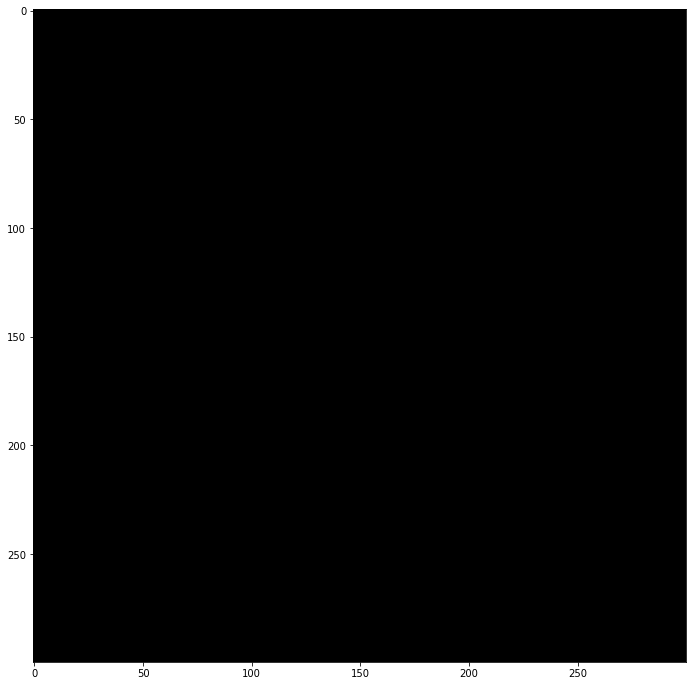

In [32]:
sample_test = x_val[9]
sample_test = sample_test * 255.0
plot_image(tf.squeeze(sample_test))

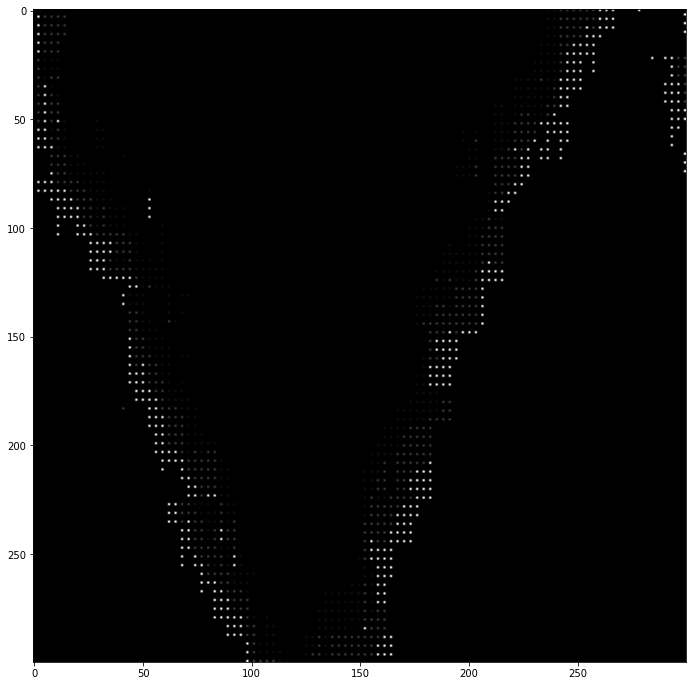

In [36]:
i = l_images[0]
plot_image(tf.squeeze(i))